# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [5]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

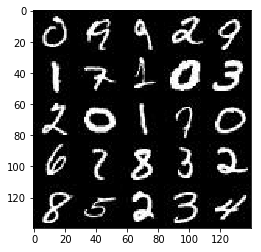

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

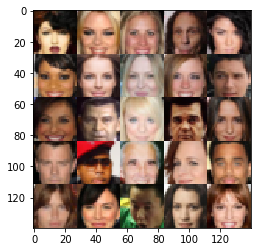

In [7]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # 12x12x64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='valid')
        x1 = tf.maximum(alpha * x1, x1)

        # 6x6x128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)

        # 6x6x256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        flat = tf.reshape(x3, (-1, 6*6*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
                
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    filters = [512, 256, 128, 32]
        
    with tf.variable_scope('generator', reuse=not is_train):
        # 7x7x512
        x1 = tf.layers.dense(z, 7*7*filters[0])
        x1 = tf.reshape(x1, (-1, 7, 7, filters[0]))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        # 14x14x256
        x2 = tf.layers.conv2d_transpose(x1, filters[1], 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        # 28x28x128        
        x3 = tf.layers.conv2d_transpose(x2, filters[2], 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, filters[3], 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    width = data_shape[1]
    height = data_shape[2]
    out_channel_dim = data_shape[3]
    
    
    real_input, z_input, lr = model_inputs(width, height, out_channel_dim, z_dim)
    
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every = 100
    print_every = 10
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1                
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, real_input: batch_images, lr: learning_rate})
                
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, out_channel_dim, data_image_mode)
                    
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images, lr: learning_rate})
                    train_loss_g = g_loss.eval({z_input: batch_z, lr: learning_rate})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),                          
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8976... Generator Loss: 6.0839
Epoch 1/2... Discriminator Loss: 0.7723... Generator Loss: 1.9308
Epoch 1/2... Discriminator Loss: 3.2740... Generator Loss: 0.1373
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 1.4645
Epoch 1/2... Discriminator Loss: 1.9349... Generator Loss: 0.3468
Epoch 1/2... Discriminator Loss: 1.8144... Generator Loss: 2.4055
Epoch 1/2... Discriminator Loss: 2.0915... Generator Loss: 0.3135
Epoch 1/2... Discriminator Loss: 1.5350... Generator Loss: 0.5006
Epoch 1/2... Discriminator Loss: 1.3696... Generator Loss: 1.2438


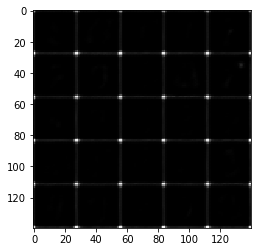

Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 1.0249
Epoch 1/2... Discriminator Loss: 1.7544... Generator Loss: 0.3947
Epoch 1/2... Discriminator Loss: 1.1449... Generator Loss: 0.8571
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 1.5666
Epoch 1/2... Discriminator Loss: 1.3846... Generator Loss: 1.2262
Epoch 1/2... Discriminator Loss: 1.4881... Generator Loss: 0.5512
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.4868... Generator Loss: 0.4756
Epoch 1/2... Discriminator Loss: 2.0020... Generator Loss: 2.3756


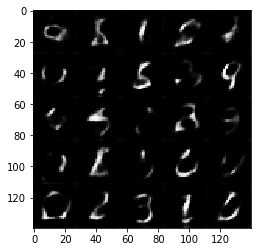

Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.7942
Epoch 1/2... Discriminator Loss: 1.2406... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 1.3606
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 1.1448... Generator Loss: 0.9692
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 0.6121
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.2286... Generator Loss: 0.9636
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 0.8517
Epoch 1/2... Discriminator Loss: 1.6154... Generator Loss: 0.4054


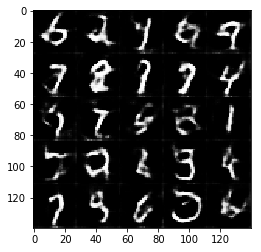

Epoch 1/2... Discriminator Loss: 1.6447... Generator Loss: 0.4378
Epoch 1/2... Discriminator Loss: 1.2559... Generator Loss: 1.1366
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 1.4593
Epoch 1/2... Discriminator Loss: 1.2722... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.4467
Epoch 1/2... Discriminator Loss: 1.5568... Generator Loss: 0.4487
Epoch 1/2... Discriminator Loss: 1.2138... Generator Loss: 1.0968
Epoch 1/2... Discriminator Loss: 1.5104... Generator Loss: 1.5760
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 1.7940
Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.7620


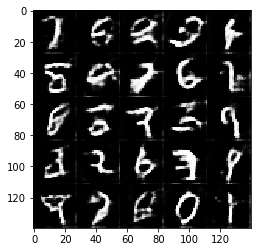

Epoch 1/2... Discriminator Loss: 1.8156... Generator Loss: 0.3333
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 0.5142
Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 0.7164
Epoch 1/2... Discriminator Loss: 1.3828... Generator Loss: 1.6715
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 1.0247
Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 1.7525
Epoch 1/2... Discriminator Loss: 1.2459... Generator Loss: 0.9947
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 1.7449
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 1.4389


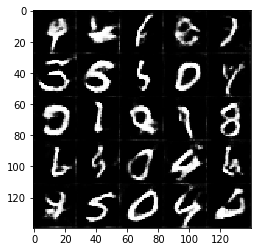

Epoch 1/2... Discriminator Loss: 1.2751... Generator Loss: 0.7201
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.7628
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.4629
Epoch 1/2... Discriminator Loss: 1.6327... Generator Loss: 0.4284
Epoch 1/2... Discriminator Loss: 1.5887... Generator Loss: 0.4534
Epoch 1/2... Discriminator Loss: 1.1491... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 1.1988
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 1.1761
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 1.5413
Epoch 1/2... Discriminator Loss: 1.5386... Generator Loss: 0.4533


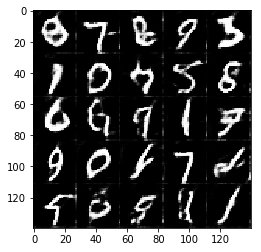

Epoch 1/2... Discriminator Loss: 1.5028... Generator Loss: 2.1031
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.5525
Epoch 1/2... Discriminator Loss: 1.3825... Generator Loss: 1.2397
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 1.4059
Epoch 1/2... Discriminator Loss: 1.1780... Generator Loss: 1.2362
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 1.5935
Epoch 1/2... Discriminator Loss: 1.1466... Generator Loss: 0.9710
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 1.2556
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 1.8476


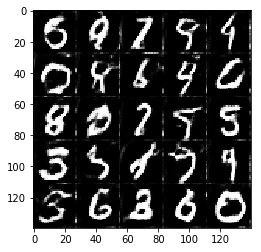

Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.5308
Epoch 1/2... Discriminator Loss: 1.1132... Generator Loss: 1.2519
Epoch 1/2... Discriminator Loss: 1.1982... Generator Loss: 1.1692
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 2.2621
Epoch 1/2... Discriminator Loss: 1.6276... Generator Loss: 0.4010
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.8669
Epoch 1/2... Discriminator Loss: 1.0647... Generator Loss: 1.0849
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.5185
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.7845


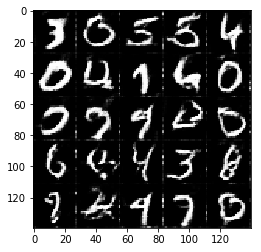

Epoch 1/2... Discriminator Loss: 1.1904... Generator Loss: 0.8989
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 1.2168
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 1.1844
Epoch 1/2... Discriminator Loss: 1.0898... Generator Loss: 1.4560
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 1.3166
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.5715... Generator Loss: 0.4861
Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 1.3727
Epoch 1/2... Discriminator Loss: 0.9721... Generator Loss: 1.3104
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.7908


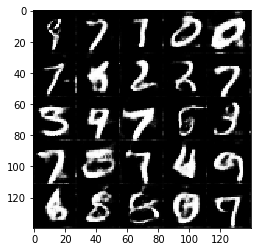

Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 1.6396
Epoch 1/2... Discriminator Loss: 1.3123... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 1.8107
Epoch 1/2... Discriminator Loss: 1.2248... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.7307
Epoch 2/2... Discriminator Loss: 1.1244... Generator Loss: 1.1510
Epoch 2/2... Discriminator Loss: 1.2076... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 1.3143
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.9038


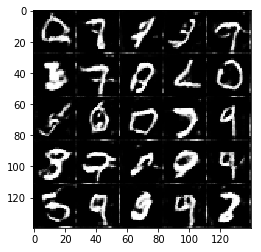

Epoch 2/2... Discriminator Loss: 1.4925... Generator Loss: 2.3025
Epoch 2/2... Discriminator Loss: 1.0079... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 1.0806
Epoch 2/2... Discriminator Loss: 1.1751... Generator Loss: 0.8024
Epoch 2/2... Discriminator Loss: 1.6082... Generator Loss: 0.4308
Epoch 2/2... Discriminator Loss: 1.4268... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.5706... Generator Loss: 0.4679
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.2852
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 1.7449


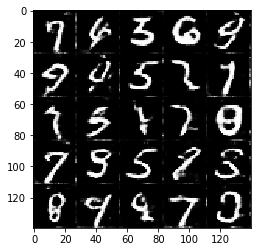

Epoch 2/2... Discriminator Loss: 1.7216... Generator Loss: 0.3970
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 1.5441
Epoch 2/2... Discriminator Loss: 1.2053... Generator Loss: 1.9663
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.6688
Epoch 2/2... Discriminator Loss: 1.1841... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.0452... Generator Loss: 1.2179
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 1.1695... Generator Loss: 1.3879
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 1.0265
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.5377


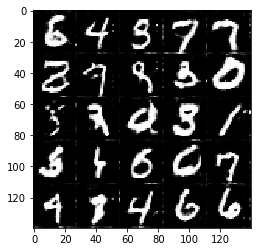

Epoch 2/2... Discriminator Loss: 1.1319... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 2.0584
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 1.2298
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 1.2201
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 1.4357
Epoch 2/2... Discriminator Loss: 1.2338... Generator Loss: 0.7520
Epoch 2/2... Discriminator Loss: 1.3102... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 1.4089
Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.6547
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 1.2760


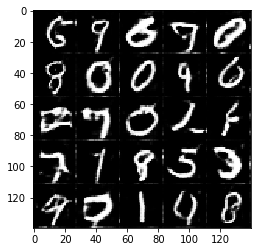

Epoch 2/2... Discriminator Loss: 1.0379... Generator Loss: 0.9552
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 2.1729
Epoch 2/2... Discriminator Loss: 1.1983... Generator Loss: 1.3855
Epoch 2/2... Discriminator Loss: 1.2407... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 1.3772
Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 0.8564
Epoch 2/2... Discriminator Loss: 1.0700... Generator Loss: 1.3869
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 0.8456
Epoch 2/2... Discriminator Loss: 1.0855... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 0.9868


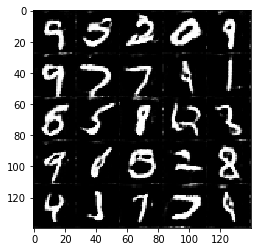

Epoch 2/2... Discriminator Loss: 1.0244... Generator Loss: 1.0327
Epoch 2/2... Discriminator Loss: 1.4072... Generator Loss: 0.5379
Epoch 2/2... Discriminator Loss: 1.1178... Generator Loss: 0.9742
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 2.3908
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 0.9960
Epoch 2/2... Discriminator Loss: 1.4736... Generator Loss: 0.5399
Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 1.0694
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 1.1351
Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.5446
Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 1.2176


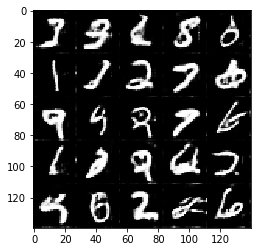

Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 0.6391
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 0.7528
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 1.0915
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 1.0525
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 1.1263
Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 1.7380
Epoch 2/2... Discriminator Loss: 1.0008... Generator Loss: 1.2336
Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.6485


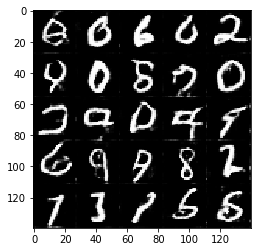

Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 1.2702... Generator Loss: 0.6504
Epoch 2/2... Discriminator Loss: 1.4545... Generator Loss: 0.5426
Epoch 2/2... Discriminator Loss: 1.0923... Generator Loss: 0.8582
Epoch 2/2... Discriminator Loss: 0.9841... Generator Loss: 1.7192
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.8191
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 1.2983
Epoch 2/2... Discriminator Loss: 1.0264... Generator Loss: 1.0353
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 1.1417
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 1.1395


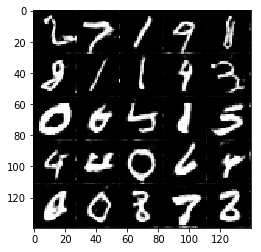

Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 1.2821... Generator Loss: 0.6573
Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 1.1481
Epoch 2/2... Discriminator Loss: 1.0524... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 1.4184... Generator Loss: 2.4585
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 1.3137
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 1.0487... Generator Loss: 1.3766
Epoch 2/2... Discriminator Loss: 1.3944... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.3356


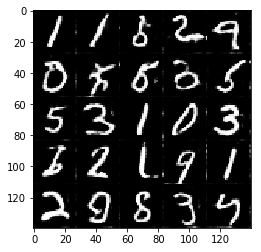

Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 1.2559
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 0.7226
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.6855
Epoch 2/2... Discriminator Loss: 1.2048... Generator Loss: 1.0608
Epoch 2/2... Discriminator Loss: 0.9458... Generator Loss: 1.5044
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 2.0973
Epoch 2/2... Discriminator Loss: 0.8555... Generator Loss: 1.5924
Epoch 2/2... Discriminator Loss: 1.2570... Generator Loss: 0.6752


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 4.6121
Epoch 1/1... Discriminator Loss: 3.8196... Generator Loss: 0.1077
Epoch 1/1... Discriminator Loss: 0.8274... Generator Loss: 2.7248
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.9237
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 2.9715
Epoch 1/1... Discriminator Loss: 0.7086... Generator Loss: 2.3639
Epoch 1/1... Discriminator Loss: 2.0154... Generator Loss: 0.3356


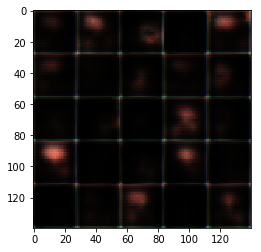

Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.4867
Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 1.0445
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.6936... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 1.6594
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.6734... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.8856... Generator Loss: 1.6994


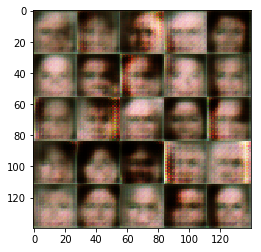

Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.2018... Generator Loss: 0.9464
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6748


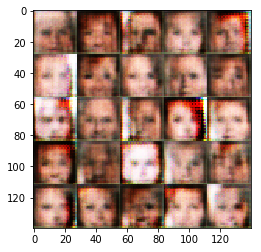

Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.8048... Generator Loss: 1.5499
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.6120... Generator Loss: 0.6828


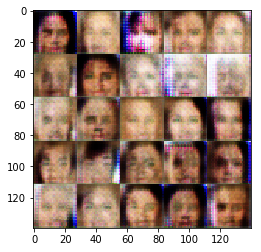

Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.4345
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.8316... Generator Loss: 0.3931
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.5430
Epoch 1/1... Discriminator Loss: 1.9144... Generator Loss: 0.2552
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.8919


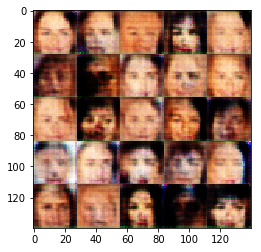

Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 1.2651
Epoch 1/1... Discriminator Loss: 1.5324... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.6889... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.9238


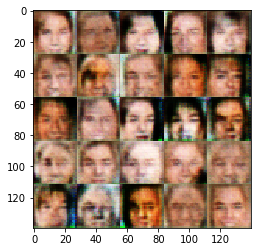

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 1.2116
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 1.6856
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9902


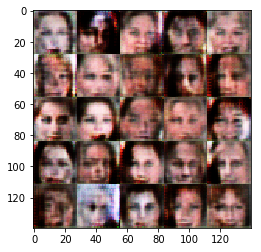

Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.1628
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.6941


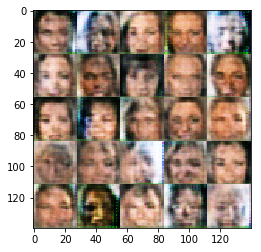

Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.4105
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.9003


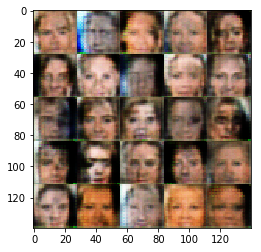

Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.6517
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.6041... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.7652


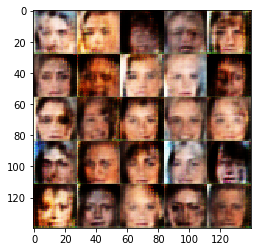

Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 1.3032
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.9648
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 1.0161


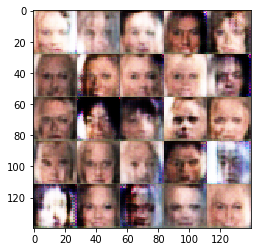

Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 1.2254
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.8429


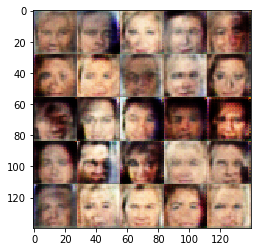

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 1.1752
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.9221


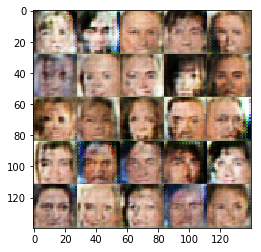

Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.9690
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.7420


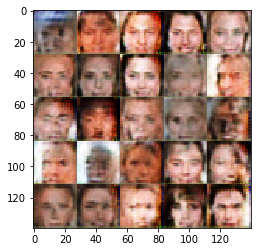

Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 1.1192
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6703


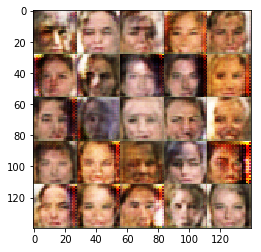

Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7604


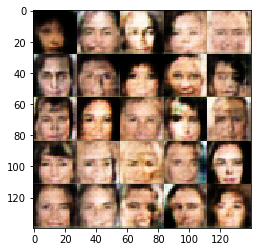

Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.7233
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7534


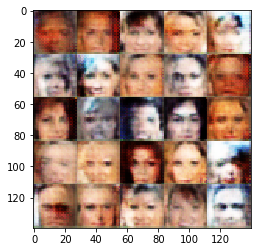

Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.6705


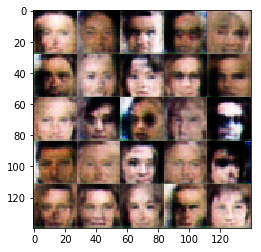

Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 1.0223
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.5830


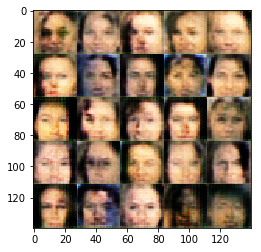

Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 1.6650
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 1.2412
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.5064... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 1.3045
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 1.7946... Generator Loss: 1.0177


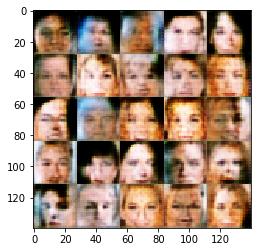

Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.9601
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8672


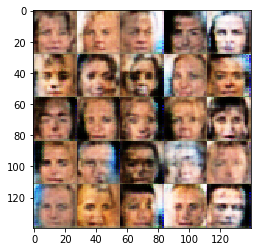

Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8538


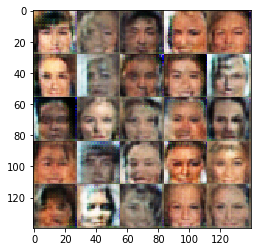

Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.9178
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 1.2707
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.9831
Epoch 1/1... Discriminator Loss: 1.5581... Generator Loss: 0.9288


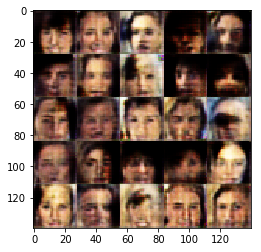

Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.0021
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 1.0418
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.9124


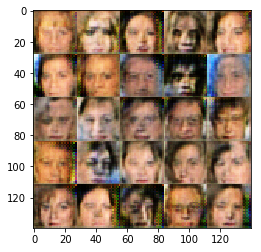

Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.8137


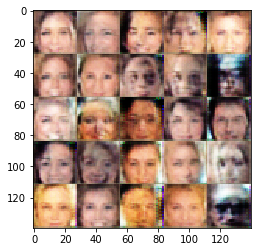

Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.6797... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.5063
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8582


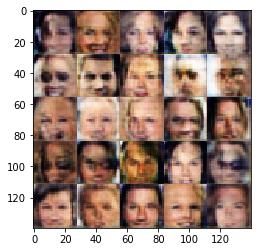

Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.7185... Generator Loss: 0.4561
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6232
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.8445
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.8285


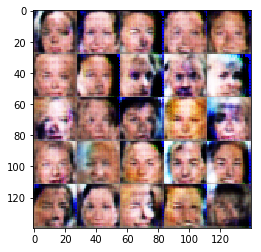

Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.9488... Generator Loss: 0.3671
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 0.8408... Generator Loss: 1.1043
Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 0.3814
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.9365


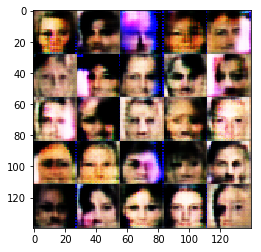

Epoch 1/1... Discriminator Loss: 0.9894... Generator Loss: 1.2822
Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.9704
Epoch 1/1... Discriminator Loss: 1.1196... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.8803


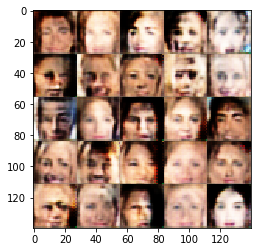

Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 1.0256
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.8287


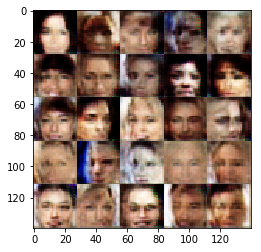

Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.9804
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.8613


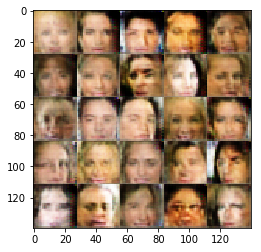

Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.5459... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.8084


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.